# In this notebook, we will train a deep learning models to predict the cloud formations

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


First, we only want to predict the labels of the cloud formation, not the masks


Some imports:

In [10]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os

Import of the data and adapting the DF for keras


In [11]:

## Il faut indiquer ou se trouve les fichiers Kaggle (si pas au même endroit):
path_kaggle_data_gdrive = ''

## Dataset Creation

In [12]:
#Import du dataset et quelques modifs


train = pd.read_csv(path_kaggle_data_gdrive + 'train.csv')

#separation de la colonne Image_label en 2 : Image et Formation
train['Image'] = train['Image_Label'].apply(lambda name: name.split('_')[0])
train['Formation'] = train['Image_Label'].apply(lambda name: name.split('_')[1])
#suppression colonne Image_label et na
train = train.drop('Image_Label', axis = 1)
train = train.dropna()

train= train[['Image', 'Formation', 'EncodedPixels']]

train = train.reset_index() #reset des index
train = train.drop('index', axis = 1) #suppression de la colonne index

train.head()

,Image,Formation,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
3,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
4,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


In [13]:
# We format the dataset to make it understandable  by keras
train_keras = train.groupby("Image")['Formation'].apply(lambda tags: ','.join(tags)) #pour chaque image on groupe les labels en séparant par ','
train_keras = pd.DataFrame(train_keras)
train_keras['Formation']=train_keras['Formation'].apply(lambda x:x.split(",")) #passage labels dans liste ex: [Fish,Flower]


df = pd.DataFrame()

df['path'] = path_kaggle_data_gdrive + 'train_images/' + train_keras.index #colonne qui donne chemin image
df['formations'] = train_keras['Formation'].values #intégration de la colonne Formation de train_keras dans df

df.head()



,path,formations
0,train_images/0011165.jpg,"[Fish, Flower]"
1,train_images/002be4f.jpg,"[Fish, Flower, Sugar]"
2,train_images/0031ae9.jpg,"[Fish, Flower, Sugar]"
3,train_images/0035239.jpg,"[Flower, Gravel]"
4,train_images/003994e.jpg,"[Fish, Gravel, Sugar]"


In [14]:
## We perform a one hot encoding
labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True) #instanciation MultiLabelBinarizer (one hot encoding)

#ajouter à df une colonne one hot encoding à partir de df['formations']
df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df['formations']),
                index=df.index,
                columns=mlb.classes_))

df.head()

,path,formations,Fish,Flower,Gravel,Sugar
0,train_images/0011165.jpg,"[Fish, Flower]",1,1,0,0
1,train_images/002be4f.jpg,"[Fish, Flower, Sugar]",1,1,0,1
2,train_images/0031ae9.jpg,"[Fish, Flower, Sugar]",1,1,0,1
3,train_images/0035239.jpg,"[Flower, Gravel]",0,1,1,0
4,train_images/003994e.jpg,"[Fish, Gravel, Sugar]",1,0,1,1


### Plots

Now that the Dataframe is made, we can plot randomly some images





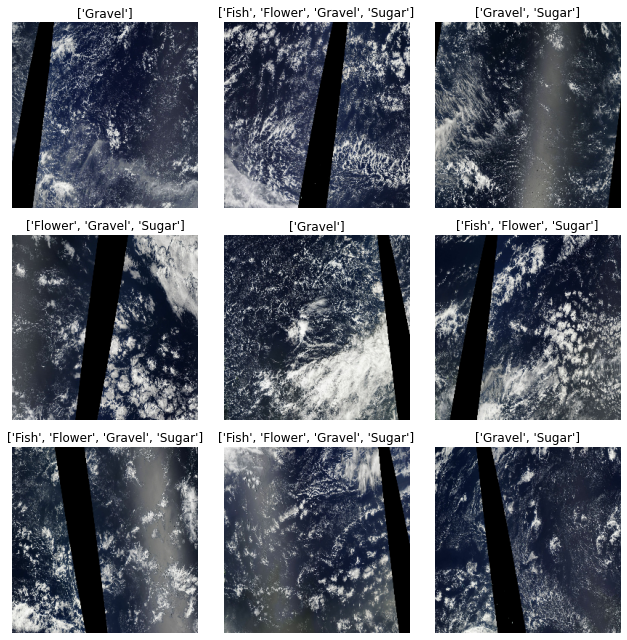

In [15]:

fig, ax = plt.subplots(figsize=(9,9), nrows=3,ncols=3 ) #creation d'une grille 3x3

for i,n in enumerate(np.random.randint(0, high=len(df), size=9)):
    #chemin de l'image
    filepath = df.path[n]
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    #On resize
    im2 = tf.image.resize(im, size=(256,256))
    img_resize = tf.cast(im2,'int64') # this line is mandatory, otherwise it doesn't plot properly    
    #On plot
    ax.ravel()[i].imshow(img_resize)
    ax.ravel()[i].set_title(df.formations[n])
    ax.ravel()[i].set_axis_off()
plt.tight_layout() #pour s adapter à la figure
plt.show()   


Creation of the train/test dataset

In [16]:
#pour efficientnet

#fonction pour charger l'image et la resizer
@tf.function
def load_image_efficientnet(filepath, resize=(256, 256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)

    return tf.image.resize(im, resize)

#decoupage train et test data : input image (path) et output colonnes labels one hot
X_train_path, X_test_path, y_train, y_test = train_test_split(df.path, df[labels], train_size=0.8)

#creation dataset train avec chargement automatique des images, resize + chargement label quand besoin par batch de 32 
dataset_train_efficientnet = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train_efficientnet = dataset_train_efficientnet.map(lambda x, y : [load_image_efficientnet(x), y], num_parallel_calls=-1).batch(32)

#creation dataset test avec chargement automatique des images, resize + chargement label quand besoin par batch de 32
dataset_test_efficientnet = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test_efficientnet = dataset_test_efficientnet.map(lambda x, y : [load_image_efficientnet(x), y], num_parallel_calls=-1).batch(32)

In [17]:
#pour inception_resnet

from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

#fonction pour charger l'image et la resizer
@tf.function
def load_image_inception_resnet(filepath, resize=(256, 256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
    im = tf.image.resize(im, resize)
    im = preprocess_input(im) ## this line is mandatory if we use inception resnet model 
    return im

#decoupage train et test data : input image (path) et output colonnes labels one hot
X_train_path, X_test_path, y_train, y_test = train_test_split(df.path, df[labels], train_size=0.8)

#creation dataset train avec chargement automatique des images, resize + chargement label quand besoin par batch de 32 
dataset_train_inception_resnet = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train_inception_resnet = dataset_train_inception_resnet.map(lambda x, y : [load_image_inception_resnet(x), y], num_parallel_calls=-1).batch(32)

#creation dataset test avec chargement automatique des images, resize + chargement label quand besoin par batch de 32
dataset_test_inception_resnet = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test_inception_resnet = dataset_test_inception_resnet.map(lambda x, y : [load_image_inception_resnet(x), y], num_parallel_calls=-1).batch(32)

## Efficient Net Model

Creation of the Deep learning models

In [18]:
from tensorflow.keras.applications import EfficientNetB1

# Chargement du modèle efficientNet
efficientNet = EfficientNetB1(include_top=False, input_shape=(256,256,3))

# Blocage du backbone
for layer in efficientNet.layers:
    layer.trainable = False

    

In [19]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model_efficientNet = Sequential()
model_efficientNet.add(efficientNet)
model_efficientNet.add(GlobalAveragePooling2D())
model_efficientNet.add(Dense(1024, activation='relu'))
model_efficientNet.add(Dropout(0.2))
model_efficientNet.add(Dense(512, activation='relu'))
model_efficientNet.add(Dropout(0.2))
model_efficientNet.add(Dense(4, activation='sigmoid'))
model_efficientNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

### Model Training

In [25]:
from tensorflow.keras import callbacks

## Model Compilation

model_efficientNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                            loss=tf.keras.losses.BinaryCrossentropy(), 
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

coarse_training = True  ## Set to true if you want to train the last layer
fine_training = False ## Set to true if you want to train all the last layers

## Creation of the directory to save the weights
checkpoint_path = 'C:/Users/gabri/project clouds/Input/understanding_cloud_organization/EfficientNet/'
if not os.path.exists(checkpoint_path):
  os.makedirs(checkpoint_path)


if coarse_training:
  # Sauvegarde automatique des poids  
  checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                        monitor='val_loss',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='min',
                                        save_freq='epoch')

  # Réduction automatique du taux d'apprentissage
  lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=3,
                                          factor=0.1,
                                          verbose=2)
  
  # On s'arrête quand le val_loss ne diminue plus
  early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                           patience = 5, 
                                           mode = 'min', 
                                           restore_best_weights=True)
  

  # entrainement du modèle
  history_eff1=model_efficientNet.fit(dataset_train_efficientnet, epochs=30, validation_data=dataset_test_efficientnet, 
                         callbacks=[lr_plateau, checkpoint, early_stopping])


if fine_training:
  ## Débloquage du backbone
  for layer in efficientNet.layers:
      layer.trainable = True
  ## Recompilation
  model_efficientNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])
  
  # entrainement du modèle
  history_eff2=model_efficientNet.fit(dataset_train_efficientnet, epochs=30, validation_data=dataset_test_efficientnet,
                         callbacks=[lr_plateau, checkpoint, early_stopping])



else:
  model_efficientNet.load_weights(checkpoint_path)



139/139 [==============================] - 522s 4s/step - loss: 0.5976 - binary_accuracy: 0.6739 - val_loss: 0.5740 - val_binary_accuracy: 0.6968


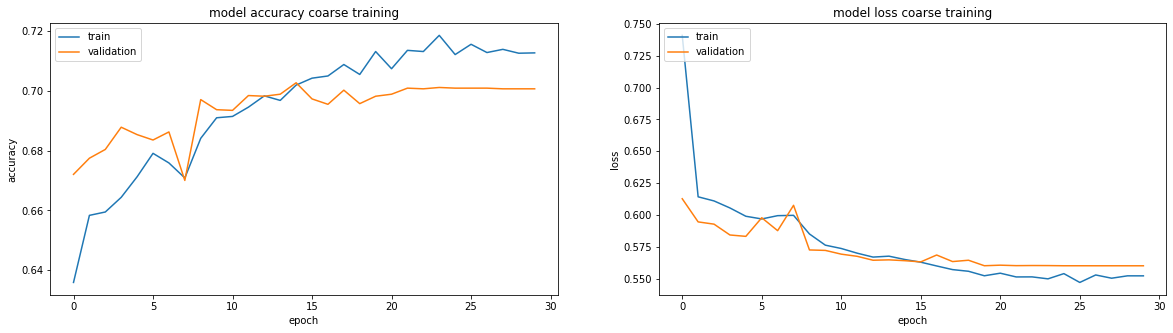

In [ ]:
# summarize history for accuracy for coarse training
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history_eff1.history['binary_accuracy'])
plt.plot(history_eff1.history['val_binary_accuracy'])
plt.title('model accuracy coarse training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history_eff1.history['loss'])
plt.plot(history_eff1.history['val_loss'])
plt.title('model loss coarse training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
#On obtient pour EfficientNet une valeur de binary accuracy égale à 0.7 sur la population de validation.

### Model Performance

In [ ]:
model_efficientNet.load_weights(checkpoint_path)

In [ ]:
## Model Predictions
threshold = 0.5 #seuil de proba qui permet de séparer les presence/absence

y_pred_proba = model_efficientNet.predict(dataset_test_efficientnet) #val de proba
y_pred = (y_pred_proba > threshold).astype(np.int) #predictions presence/absence

In [ ]:
# Confusion Matrix multilabel (car on a 2 classes presence/absence par formation)
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test, y_pred)

for i, label in enumerate(y_test.columns.to_list()):
  print(label)
  print(cm[i])

Fish
[[352 207]
 [167 384]]
Flower
[[555  88]
 [147 320]]
Gravel
[[294 224]
 [163 429]]
Sugar
[[ 72 301]
 [ 32 705]]


In [ ]:
#On observe sur les matrices de confusion, une assez bonne reconnaissance des Fish et des Flower. Par contre pour les Sugar, le modèle a tendance à beaucoup prédire en 1 (présence).

In [ ]:
#Classification Report

from sklearn.metrics import classification_report

label_names = y_test.columns.to_list()
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

        Fish       0.65      0.70      0.67       551
      Flower       0.78      0.69      0.73       467
      Gravel       0.66      0.72      0.69       592
       Sugar       0.70      0.96      0.81       737

   micro avg       0.69      0.78      0.73      2347
   macro avg       0.70      0.77      0.73      2347
weighted avg       0.69      0.78      0.73      2347
 samples avg       0.71      0.82      0.72      2347



## Inception Resnet

Creation of the Deep learning models

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

# Chargement du modèle InceptionResnNet
inceptionResNetV2 = InceptionResNetV2(include_top=False, input_shape=(256,256,3))

# Blocage du backbone
for layer in inceptionResNetV2.layers:
    layer.trainable = False
    

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model_inceptionResNetV2 = Sequential()
model_inceptionResNetV2.add(inceptionResNetV2)
model_inceptionResNetV2.add(GlobalAveragePooling2D())
model_inceptionResNetV2.add(Dense(1024, activation='relu'))
model_inceptionResNetV2.add(Dropout(0.2))
model_inceptionResNetV2.add(Dense(512, activation='relu'))
model_inceptionResNetV2.add(Dropout(0.2))
model_inceptionResNetV2.add(Dense(4, activation='sigmoid'))
model_inceptionResNetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

### Model Training

In [ ]:
from tensorflow.keras import callbacks

## Model Compilation

model_inceptionResNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

coarse_training = True  ## Set to true if you want to train the last layer
fine_training = False ## Set to true if you want to train all the last layers

## Creation of the directory to save the weights
checkpoint_path = '/InceptionResNetV2/'
if not os.path.exists(checkpoint_path):
  os.makedirs(checkpoint_path)


if coarse_training:
  # Sauvegarde automatique des poids  
  checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                        monitor='val_loss',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='min',
                                        save_freq='epoch')

  # Réduction automatique du taux d'apprentissage
  lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=3,
                                          factor=0.1,
                                          verbose=2)
  
  # On s'arrête quand le val_loss ne diminue plus
  early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                           patience = 5, 
                                           mode = 'min', 
                                           restore_best_weights=True)
  

  # entrainement du modèle
  history_incept1=model_inceptionResNetV2.fit(dataset_train_inception_resnet, epochs=30, validation_data=dataset_test_inception_resnet, 
                         callbacks=[lr_plateau, checkpoint, early_stopping])


if fine_training:
  ## Déblocage du backbone
  for layer in efficientNet.layers:
      layer.trainable = True
  ## Recompilation
  model_inceptionResNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])
  
  # entrainement du modèle
  history_incept2=model_inceptionResNetV2.fit(dataset_train_inception_resnet, epochs=30, validation_data=dataset_test_inception_resnet, 
                         callbacks=[lr_plateau, checkpoint, early_stopping])



else:
  model_inceptionResNetV2.load_weights(checkpoint_path)



Epoch 1/30
139/139 [==============================] - 1035s 7s/step - loss: 1.0584 - binary_accuracy: 0.6022 - val_loss: 0.6596 - val_binary_accuracy: 0.6207 - lr: 0.0100
Epoch 2/30
139/139 [==============================] - 232s 2s/step - loss: 0.6489 - binary_accuracy: 0.6141 - val_loss: 0.6425 - val_binary_accuracy: 0.6209 - lr: 0.0100
Epoch 3/30
139/139 [==============================] - 98s 707ms/step - loss: 0.6399 - binary_accuracy: 0.6227 - val_loss: 0.6511 - val_binary_accuracy: 0.6171 - lr: 0.0100
Epoch 4/30
139/139 [==============================] - 102s 731ms/step - loss: 0.6406 - binary_accuracy: 0.6196 - val_loss: 0.6448 - val_binary_accuracy: 0.6282 - lr: 0.0100
Epoch 5/30
139/139 [==============================] - 243s 2s/step - loss: 0.6371 - binary_accuracy: 0.6239 - val_loss: 0.6362 - val_binary_accuracy: 0.6426 - lr: 0.0100
Epoch 6/30
139/139 [==============================] - 99s 709ms/step - loss: 0.6352 - binary_accuracy: 0.6287 - val_loss: 0.6415 - val_binary_ac

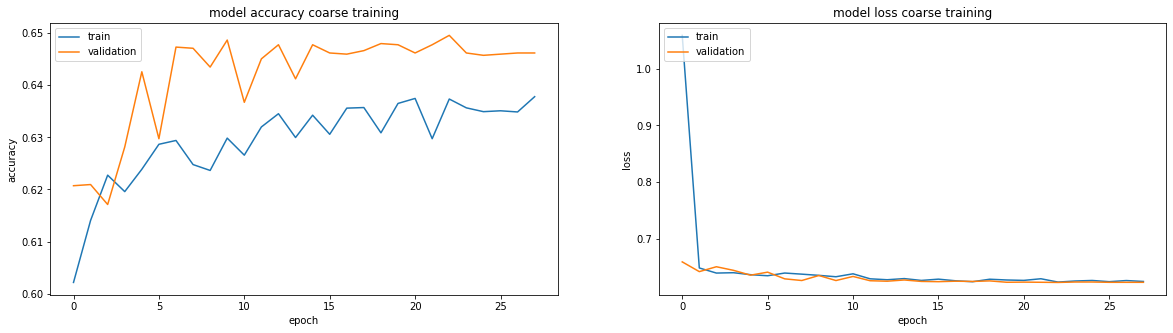

In [ ]:
# summarize history for accuracy for coarse training
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history_incept1.history['binary_accuracy'])
plt.plot(history_incept1.history['val_binary_accuracy'])
plt.title('model accuracy coarse training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history_incept1.history['loss'])
plt.plot(history_incept1.history['val_loss'])
plt.title('model loss coarse training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
#On obtient pour Inception Resnet une valeur de binary accuracy égale à 0.65 sur la population de validation.

### Model Performance

In [ ]:
model_inceptionResNetV2.load_weights(checkpoint_path)

## Model Predictions
threshold = 0.5

y_pred_proba = model_inceptionResNetV2.predict(dataset_test_inception_resnet)
y_pred = (y_pred_proba > threshold).astype(np.int)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test, y_pred)

for i, label in enumerate(y_test.columns.to_list()):
  print(label)
  print(cm[i])

Fish
[[315 217]
 [297 281]]
Flower
[[496 123]
 [154 337]]
Gravel
[[313 200]
 [188 409]]
Sugar
[[  0 377]
 [  0 733]]


In [ ]:
#On observe sur les matrices de confusion, une assez bonne reconnaissance des Flower et des Gravel. Par contre pour les Sugar, le modèle prédit tout en 1 (présence).


In [ ]:
#Classification Report

from sklearn.metrics import classification_report

label_names = y_test.columns.to_list()
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

        Fish       0.56      0.49      0.52       578
      Flower       0.73      0.69      0.71       491
      Gravel       0.67      0.69      0.68       597
       Sugar       0.66      1.00      0.80       733

   micro avg       0.66      0.73      0.69      2399
   macro avg       0.66      0.71      0.68      2399
weighted avg       0.65      0.73      0.68      2399
 samples avg       0.67      0.76      0.67      2399



Source: https://medium.com/deep-learning-with-keras/how-to-solve-multi-label-classification-problems-in-deep-learning-with-tensorflow-keras-7fb933243595